<a href="https://colab.research.google.com/github/raimasood93/github-slideshow/blob/master/BayesOptMultiFidelity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emukit

     |████████████████████████████████| 153kB 4.0MB/s 
     |████████████████████████████████| 962kB 23.4MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
  Created wheel for emukit: filename=emukit-0.4.8-cp37-none-any.whl size=232215 sha256=6ac3d7318af8c442f57d1e718c69dda6fed8a78663751741fe78a072c44a7a4a
  Stored in directory: /root/.cache/pip/wheels/47/d6/3f/212aad82a1f95d5d784101f889ab11dc916a6de9fa3f1b209f
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2564970 sha256=052c348a9e9e0a1f3e6ecea894f063ea96c6ccf38c6afa0d2cc67d2c08fc74f8
  Stored in directory: /root/.cache/pip/wheels/23/99/8d/d0c3dee7db4af58190cde6abdb45e6a7ded2f9f01ff528dd0f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102566 sha256=834b27244b0f20912425bcbe0f355c2d1b335439f2c8e106eed49a0fb907521b
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf

In [2]:
# Load function
import emukit.test_functions.forrester

# The multi-fidelity Forrester function is already wrapped as an Emukit UserFunction object in 
# the test_functions package
forrester_fcn, _ = emukit.test_functions.forrester.multi_fidelity_forrester_function()
forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

# Assign costs
low_fidelity_cost = 1
high_fidelity_cost = 5

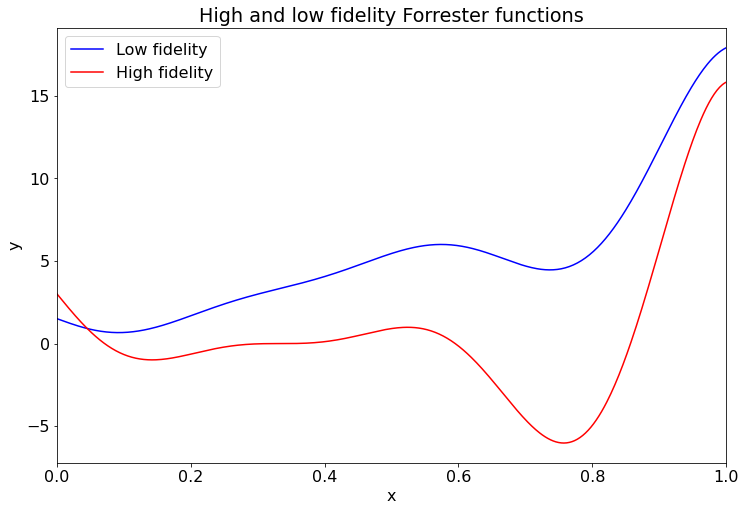

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
FIG_SIZE = (12, 8)
import numpy as np
np.random.seed(12345)
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array

n_plot_points = 100
x_plot = np.linspace(0, 1, 500)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)

plt.figure(figsize=FIG_SIZE)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Forrester functions')
plt.xlabel('x')
plt.ylabel('y');
plt.show()

In [4]:

from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
n_fidelities = 2

parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(n_fidelities)])

In [5]:

x_low = np.random.rand(12)[:, None]
x_high = x_low[:6, :]

y_low = forrester_fcn_low(x_low)
y_high = forrester_fcn_high(x_high)

In [6]:
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
import GPy
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.models.gp_regression import GPRegression

x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])

kern_low = GPy.kern.RBF(1)
kern_low.lengthscale.constrain_bounded(0.01, 0.5)

kern_err = GPy.kern.RBF(1)
kern_err.lengthscale.constrain_bounded(0.01, 0.5)

multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, n_fidelities)

gpy_model.likelihood.Gaussian_noise.fix(0.1)
gpy_model.likelihood.Gaussian_noise_1.fix(0.1)

model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
model.optimize()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


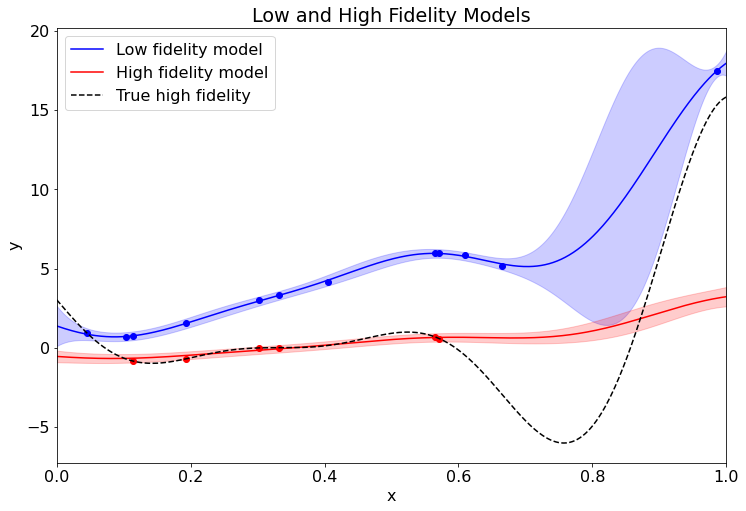

In [7]:
x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)

def plot_model(x_low, y_low, x_high, y_high):
    mean_low, var_low = model.predict(x_plot_low)
    mean_high, var_high = model.predict(x_plot_high)

    plt.figure(figsize=FIG_SIZE)
    def plot_with_error_bars(x, mean, var, color):
        plt.plot(x, mean, color=color)
        plt.fill_between(x.flatten(), mean.flatten() - 1.96*var.flatten(), mean.flatten() + 1.96*var.flatten(), 
                        alpha=0.2, color=color)

    plot_with_error_bars(x_plot_high[:, 0], mean_low, var_low, 'b')
    plot_with_error_bars(x_plot_high[:, 0], mean_high, var_high, 'r')
    plt.plot(x_plot, forrester_fcn_high(x_plot), 'k--')
    plt.scatter(x_low, y_low, color='b')
    plt.scatter(x_high, y_high, color='r')
    plt.legend(['Low fidelity model', 'High fidelity model', 'True high fidelity'])
    plt.title('Low and High Fidelity Models')
    plt.xlim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y');
    plt.show()
    
plot_model(x_low, y_low, x_high, y_high)

In [8]:
from emukit.bayesian_optimization.acquisitions.entropy_search import MultiInformationSourceEntropySearch
from emukit.core.acquisition import Acquisition

# Define cost of different fidelities as acquisition function
class Cost(Acquisition):
    def __init__(self, costs):
        self.costs = costs

    def evaluate(self, x):
        fidelity_index = x[:, -1].astype(int)
        x_cost = np.array([self.costs[i] for i in fidelity_index])
        return x_cost[:, None]
    
    @property
    def has_gradients(self):
        return True
    
    def evaluate_with_gradients(self, x):
        return self.evalute(x), np.zeros(x.shape)

cost_acquisition = Cost([low_fidelity_cost, high_fidelity_cost])
acquisition = MultiInformationSourceEntropySearch(model, parameter_space) / cost_acquisition

In [9]:
from emukit.core.loop import FixedIntervalUpdater, OuterLoop, SequentialPointCalculator
from emukit.core.loop.loop_state import create_loop_state
from emukit.core.optimization.multi_source_acquisition_optimizer import MultiSourceAcquisitionOptimizer
from emukit.core.optimization import GradientAcquisitionOptimizer

initial_loop_state = create_loop_state(x_array, y_array)
acquisition_optimizer = MultiSourceAcquisitionOptimizer(GradientAcquisitionOptimizer(parameter_space), parameter_space)
candidate_point_calculator = SequentialPointCalculator(acquisition, acquisition_optimizer)
model_updater = FixedIntervalUpdater(model)
loop = OuterLoop(candidate_point_calculator, model_updater, initial_loop_state)

In [10]:
def plot_acquisition(loop, loop_state):
    colours = ['b', 'r']
    plt.plot(x_plot_low[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_low), 'b')
    plt.plot(x_plot_high[:, 0], loop.candidate_point_calculator.acquisition.evaluate(x_plot_high), 'r')
    
    previous_x_collected = loop_state.X[[-1], :]
    fidelity_idx = int(previous_x_collected[0, -1])
    plt.scatter(previous_x_collected[0, 0], 
                loop.candidate_point_calculator.acquisition.evaluate(previous_x_collected), 
                color=colours[fidelity_idx])
    plt.legend(['Low fidelity', 'High fidelity'], fontsize=12)
    plt.title('Acquisition Function at Iteration ' + str(loop_state.iteration))
    plt.xlabel('x')
    plt.xlim(0, 1)
    plt.ylabel('Acquisition Value')
    plt.tight_layout()
    plt.show()
    
loop.iteration_end_event.append(plot_acquisition)

In [11]:
x_search = np.stack([np.linspace(0, 1, 1000), np.ones(1000)], axis=1)

model_min_mean = []
model_min_loc = []
def calculate_metrics(loop, loop_state):
    mean, var = loop.model_updaters[0].model.predict(x_search)
    model_min_mean.append(np.min(mean))
    model_min_loc.append(x_search[np.argmin(mean), 0])

# subscribe to event
loop.iteration_end_event.append(calculate_metrics)

In [12]:

loop.run_loop(forrester_fcn, 10)

TypeError: ignored